In [1]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm import tqdm

# Анализ

## 1.1. Выбор набора данных

In [2]:
path = '/Users/stu/Desktop/Курсач/Datasets/MOEX_shares_prices.csv'
data = pd.read_csv(path)
data

,secid,isin,tradedate,open,close,high,low,volume,is_russian
0,CHNG,NaN,2004-01-05,NaN,NaN,NaN,NaN,0,True
1,CHNGP,NaN,2004-01-05,NaN,NaN,NaN,NaN,0,True
2,CTEL,RU0009075840,2004-01-05,NaN,NaN,NaN,NaN,0,True
3,CTELP,RU0009075857,2004-01-05,NaN,NaN,NaN,NaN,0,True
4,DALE,NaN,2004-01-05,0.214,0.215,0.216,0.206,6824200,True
...,...,...,...,...,...,...,...,...,...
2437681,SAP-RM,US8030542042,2022-02-18T00:00:00,9100.000,8987.000,9100.000,8982.000,14,False
2437682,SAP-RM,US8030542042,2022-02-22T00:00:00,9107.000,8980.000,9107.000,8900.000,57,False
2437683,SAP-RM,US8030542042,2022-02-23T00:00:00,9330.000,9168.000,9330.000,9127.000,5,False
2437684,SAP-RM,US8030542042,2022-02-24T00:00:00,8090.000,8090.000,9100.000,8090.000,8,False


## 1.2. Анализ и очистка набора данных

In [3]:
data.describe(include='all')

,secid,isin,tradedate,open,close,high,low,volume,is_russian
count,2437686,2374787,2437686,1.528407e+06,1.528450e+06,1.528602e+06,1.528602e+06,2.437686e+06,2437686
unique,2768,2163,5582,NaN,NaN,NaN,NaN,NaN,2
top,SNGSP,RU0009059216,2022-02-22T00:00:00,NaN,NaN,NaN,NaN,NaN,True
freq,5209,6798,1916,NaN,NaN,NaN,NaN,NaN,2219264
mean,NaN,NaN,NaN,4.078587e+03,4.078654e+03,4.120236e+03,4.035247e+03,5.642356e+07,NaN
std,NaN,NaN,NaN,3.660267e+04,3.663945e+04,3.687272e+04,3.633725e+04,2.527703e+09,NaN
min,NaN,NaN,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN
25%,NaN,NaN,NaN,4.420000e+00,4.428625e+00,4.512000e+00,4.305000e+00,0.000000e+00,NaN
50%,NaN,NaN,NaN,9.199000e+01,9.198000e+01,9.350000e+01,9.005000e+01,4.000000e+01,NaN
75%,NaN,NaN,NaN,1.210000e+03,1.210000e+03,1.229000e+03,1.192400e+03,1.550000e+04,NaN


In [4]:
data.isna().sum()

secid              0
isin           62899
tradedate          0
open          909279
close         909236
high          909084
low           909084
volume             0
is_russian         0
dtype: int64

### Создание графика распределения длины временных рядов по ценным бумагам

In [5]:
counts = data['secid'].value_counts()

plt.figure(figsize=(12, 6))
plt.hist(counts, bins=50)
plt.xlabel('Количество записей на ценную бумагу')
plt.ylabel('Количество ценных бумаг')
plt.title('Распределение длины временных рядов по ценным бумагам')
plt.tight_layout()

name_fig = f"Распределение длины временных рядов по ценным бумагам.png"
folder_path = "Анализ"
os.makedirs(folder_path, exist_ok=True)
save_path = os.path.join(folder_path, name_fig)
    
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

### Подготовка датасета

In [7]:
def preprocessing(data):
    data = data.copy()
    data['tradedate'] = pd.to_datetime(data['tradedate'], errors='coerce')
    data = data.dropna(subset=['tradedate'])
    data['day_of_week'] = data['tradedate'].dt.dayofweek
    data['is_monday'] = (data['day_of_week'] == 0).astype(int)
    data['is_friday'] = (data['day_of_week'] == 4).astype(int)
    data['days_from_start'] = data.groupby('secid')['tradedate'].transform(lambda x: (x - x.min()).dt.days)
    
    data = data.sort_values(['secid', 'days_from_start'])
    data['return_tomorrow'] = data.groupby('secid')['open'].shift(-1) / data['open'] - 1

    for lag in [1, 2, 3, 5, 10]:
        data[f'return_lag_{lag}'] = data.groupby('secid')['open'].pct_change(lag)

    for w in [5, 10, 20]:
        data[f'momentum_{w}'] = data.groupby('secid')['open'].transform(lambda x: x / x.shift(w) - 1)

    data['daily_range'] = (data['high'] - data['low']) / data['open']
    data['intraday_return'] = (data['close'] - data['open']) / data['open']
    data['prev_close'] = data.groupby('secid')['close'].shift(1)
    data['overnight_return'] = data['open'] / data['prev_close'] - 1
    
    data['volume'] = data.groupby('secid')['volume'].transform(lambda x: x.replace(0, x[x>0].min() if (x>0).any() else 1))
    for w in [3, 5, 10]:
        data[f'vol_avg_{w}'] = data.groupby('secid')['volume'].transform(
            lambda x: x.shift(1).rolling(w, min_periods=1).mean()
        )
        data[f'vol_change_{w}'] = data.groupby('secid')['volume'].transform(lambda x: x / x.shift(w) - 1)

    
    data = data.replace([np.inf, -np.inf], np.nan)
    features = ['open', 'close', 'high', 'low', 'volume', 'days_from_start', 'is_monday', 'is_friday', 'return_lag_1', 'return_lag_2', 'return_lag_3', 'return_lag_5', 'return_lag_10', 'momentum_5', 'momentum_10', 'momentum_20', 'daily_range', 'intraday_return', 'overnight_return', 'vol_avg_3', 'vol_avg_5', 'vol_avg_10', 'vol_change_3', 'vol_change_5', 'vol_change_10']
    target = 'return_tomorrow'
    data = data.dropna(subset=features + [target])
    data = data[(data['open'] != 0) & (data['close'] != 0) & (data['high'] != 0) & (data['low'] != 0)]
    
    secid_counts = data['secid'].value_counts()
    secid_left = secid_counts[secid_counts >= 350].index
    data = data[data['secid'].isin(secid_left)].copy()

    data = data.sort_values(['secid', 'tradedate']).reset_index(drop=True)
    return data, features, target

data, features, target = preprocessing(data)
data

/var/folders/rb/58w84x9s75qdfw3r5pkpn6ph0000gn/T/ipykernel_49365/2212296641.py:14: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[f'return_lag_{lag}'] = data.groupby('secid')['open'].pct_change(lag)
/var/folders/rb/58w84x9s75qdfw3r5pkpn6ph0000gn/T/ipykernel_49365/2212296641.py:14: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  data[f'return_lag_{lag}'] = data.groupby('secid')['open'].pct_change(lag)
/var/folders/rb/58w84x9s75qdfw3r5pkpn6ph0000gn/T/ipykernel_49365/2212296641.py:14: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and wi

,secid,isin,tradedate,open,close,high,low,volume,is_russian,day_of_week,...,daily_range,intraday_return,prev_close,overnight_return,vol_avg_3,vol_change_3,vol_avg_5,vol_change_5,vol_avg_10,vol_change_10
0,ABRD,RU000A0JS5T7,2012-05-10,5471.00,5485.00,5485.00,5455.00,434,True,3,...,0.005483,0.002559,5451.00,0.003669,480.333333,-0.035556,445.6,0.589744,580.0,-0.498266
1,ABRD,RU000A0JS5T7,2012-05-11,5475.00,5490.00,5497.00,5475.00,516,True,4,...,0.004018,0.002740,5485.00,-0.001823,475.000000,0.057377,477.8,0.003891,536.9,0.015748
2,ABRD,RU000A0JS5T7,2012-05-12,5492.00,5495.00,5497.00,5490.00,239,True,5,...,0.001275,0.000546,5490.00,0.000364,484.333333,-0.524851,478.2,-0.468889,537.7,-0.648529
3,ABRD,RU000A0JS5T7,2012-05-14,5492.00,5455.00,5492.00,5455.00,541,True,0,...,0.006737,-0.006737,5495.00,-0.000546,396.333333,0.246544,436.0,0.108607,493.6,-0.346618
4,ABRD,RU000A0JS5T7,2012-05-15,5426.00,5455.00,5465.00,5405.00,334,True,1,...,0.011058,0.005345,5455.00,-0.005316,432.000000,-0.352713,446.6,-0.335984,464.9,-0.516643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1022413,ZVEZ,RU0009091300,2024-12-04,6.68,7.00,7.34,6.68,94000,True,2,...,0.098802,0.047904,6.83,-0.021962,82666.666667,-0.381579,103400.0,-0.543689,88900.0,4.875000
1022414,ZVEZ,RU0009091300,2024-12-05,7.06,6.81,7.06,6.74,65000,True,3,...,0.045326,-0.035411,7.00,0.008571,63333.333333,2.095238,81000.0,0.031746,96700.0,0.477273
1022415,ZVEZ,RU0009091300,2024-12-06,7.00,7.06,7.06,6.92,36000,True,4,...,0.020000,0.008571,6.81,0.027900,78000.000000,-0.520000,81400.0,-0.763158,98800.0,-0.709677
1022416,ZVEZ,RU0009091300,2024-12-09,6.97,7.12,7.22,6.97,28000,True,0,...,0.035868,0.021521,7.06,-0.012748,65000.000000,-0.702128,58200.0,0.333333,90000.0,-0.685393


In [8]:
data.shape, data['secid'].nunique()

((1022418, 32), 618)

In [9]:
data[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022418 entries, 0 to 1022417
Data columns (total 25 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   open              1022418 non-null  float64
 1   close             1022418 non-null  float64
 2   high              1022418 non-null  float64
 3   low               1022418 non-null  float64
 4   volume            1022418 non-null  int64  
 5   days_from_start   1022418 non-null  int64  
 6   is_monday         1022418 non-null  int64  
 7   is_friday         1022418 non-null  int64  
 8   return_lag_1      1022418 non-null  float64
 9   return_lag_2      1022418 non-null  float64
 10  return_lag_3      1022418 non-null  float64
 11  return_lag_5      1022418 non-null  float64
 12  return_lag_10     1022418 non-null  float64
 13  momentum_5        1022418 non-null  float64
 14  momentum_10       1022418 non-null  float64
 15  momentum_20       1022418 non-null  float64
 16  

In [10]:
counts = data['secid'].value_counts()

plt.figure(figsize=(12, 6))
plt.hist(counts, bins=50)
plt.xlabel('Количество записей на ценную бумагу')
plt.ylabel('Количество ценных бумаг')
plt.title('Распределение длины временных рядов по ценным бумагам')
plt.tight_layout()

name_fig = f"Распределение длины временных рядов по ценным бумагам (после обработки).png"
save_path = os.path.join('Анализ', name_fig)
    
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

### Анализ распределения целевой переменной для двух бумаг

In [11]:
RU0006922010 = data[data['secid'] == 'RU0006922010'][target].to_numpy()

plt.figure(figsize=(12, 6))
plt.hist(RU0006922010, bins=100)
plt.xlabel('Относительное изменение цены')
plt.ylabel('Количество наблюдений')
plt.title('Распределение целевой переменной для \'RU0006922010\'')
plt.tight_layout()

name_fig = f"Распределение целевой переменной для 'RU0006922010'.png"
save_path = os.path.join('Анализ', name_fig)
    
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

In [12]:
LQDT = data[data['secid'] == 'LQDT'][target].to_numpy()

plt.figure(figsize=(12, 6))
plt.hist(LQDT, bins=100)
plt.xlabel('Относительное изменение цены')
plt.ylabel('Количество наблюдений')
plt.title('Распределение целевой переменной для \'LQDT\'')
plt.tight_layout()

name_fig = f"Распределение целевой переменной для 'LQDT'.png"
save_path = os.path.join('Анализ', name_fig)
    
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.close()

## 1.3. Обзор ансамблевых методов машинного обучения

### Группировка данных по уникальному идентификатору

In [13]:
data_grouped = data.groupby('secid')

### RandomForestRegressor

In [14]:
direction_accuracies = []
smapes = []
for secid, group in tqdm(data_grouped, desc="Processing"):
    split_index = int(len(group) * 0.8)
    train = group.iloc[:split_index]
    test = group.iloc[split_index:]
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]
   
    rf = RandomForestRegressor(random_state=44, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    
    smape = np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test))) * 100
    direction_accuracy = np.mean(np.sign(y_test) == np.sign(y_pred))
    direction_accuracies.append(direction_accuracy) 
    smapes.append(smape)

print(f'Средний показатель direction accuracy у RandomForestRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE у RandomForestRegressor = {np.mean(smapes):.4f}')

Processing: 100%|█████████████████████████████| 618/618 [10:24<00:00,  1.01s/it]

Средний показатель direction accuracy у RandomForestRegressor = 0.7270
Средний показатель SMAPE у RandomForestRegressor = 102.9727


### XGBRegressor

In [15]:
direction_accuracies = []
smapes = []
for secid, group in tqdm(data_grouped, desc="Processing"):
    split_index = int(len(group) * 0.8)
    train = group.iloc[:split_index]
    test = group.iloc[split_index:]
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]
    
    xgb = XGBRegressor(random_state=44, n_jobs=-1)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    
    smape = np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test))) * 100
    direction_accuracy = np.mean(np.sign(y_test) == np.sign(y_pred))
    direction_accuracies.append(direction_accuracy) 
    smapes.append(smape)

print(f'Средний показатель direction accuracy у XGBRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE у XGBRegressor = {np.mean(smapes):.4f}')

Processing: 100%|█████████████████████████████| 618/618 [02:34<00:00,  3.99it/s]

Средний показатель direction accuracy у XGBRegressor = 0.7025
Средний показатель SMAPE у XGBRegressor = 108.8434


### VotingRegressor

In [16]:
direction_accuracies = []
smapes = []
for secid, group in tqdm(data_grouped, desc="Processing"):
    split_index = int(len(group) * 0.8)
    train = group.iloc[:split_index]
    test = group.iloc[split_index:]
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]
    voting = VotingRegressor([('random_forest', rf), ('xgboost', xgb)])
    voting.fit(X_train, y_train)
    y_pred = voting.predict(X_test)
    smape = np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test))) * 100
    direction_accuracy = np.mean(np.sign(y_test) == np.sign(y_pred))
    direction_accuracies.append(direction_accuracy) 
    smapes.append(smape)
print(f'Средний показатель direction accuracy у VotingRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE у VotingRegressor = {np.mean(smapes):.4f}')

Processing: 100%|█████████████████████████████| 618/618 [13:26<00:00,  1.30s/it]

Средний показатель direction accuracy у VotingRegressor = 0.7209
Средний показатель SMAPE у VotingRegressor = 104.3988


In [17]:
direction_accuracies = []
smapes = []
for secid, group in tqdm(data_grouped, desc="Processing"):
    split_index = int(len(group) * 0.8)
    train = group.iloc[:split_index]
    test = group.iloc[split_index:]
    X_train, y_train = train[features], train[target]
    X_test, y_test = test[features], test[target]
    blend_split_idx = int(0.8 * len(X_train))
    X_base = X_train[:blend_split_idx]
    y_base = y_train[:blend_split_idx]
    X_meta = X_train[blend_split_idx:]
    y_meta = y_train[blend_split_idx:]
    rf.fit(X_base, y_base)
    xgb.fit(X_base, y_base)
    meta_features = np.column_stack([
        rf.predict(X_meta),
        xgb.predict(X_meta)
    ])
    meta_model = Ridge()
    meta_model.fit(meta_features, y_meta)
    test_meta_features = np.column_stack([
        rf.predict(X_test),
        xgb.predict(X_test)
    ])
    y_pred = meta_model.predict(test_meta_features)
    smape = np.mean(2 * np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test))) * 100
    direction_accuracy = np.mean(np.sign(y_test) == np.sign(y_pred))
    direction_accuracies.append(direction_accuracy) 
    smapes.append(smape)
print(f'Средний показатель direction accuracy у Blending = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE у Blending = {np.mean(smapes):.4f}')

Processing: 100%|█████████████████████████████| 618/618 [11:28<00:00,  1.11s/it]

Средний показатель direction accuracy у Blending = 0.6389
Средний показатель SMAPE у Blending = 144.8570


# 2. ПРОЕКТИРОВАНИЕ И РЕАЛИЗАЦИЯ

## 2.1. Создание нужных моделей

In [18]:
def get_base_models():
    xgb = XGBRegressor(random_state=44, verbosity=0, n_jobs=-1)
    lgbm = LGBMRegressor(random_state=44, verbose=-1, n_jobs=-1)
    hgb = HistGradientBoostingRegressor(random_state=44)
    rf = RandomForestRegressor(random_state=44, n_jobs=-1)
    et = ExtraTreesRegressor(random_state=44, n_jobs=-1)
    ridge_pipeline = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
    knn_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsRegressor(n_jobs=-1))])
    models = [
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('rf', rf),
        ('et', et),
        ('ridge', ridge_pipeline),
        ('knn', knn_pipeline),
        ('hgb', hgb)
    ]
    return models

## 2.2. Формирование обучающей и тестирующей выборок

In [19]:
def get_sample(group, features, target, train_size=0.8):
    group = group.sort_values('days_from_start').dropna(subset=features + [target])
    split_index = int(len(group) * train_size)
    train = group.iloc[:split_index]
    test = group.iloc[split_index:]
    X_train = train[features]
    y_train = train[target]
    X_test = test[features]
    y_test = test[target]
    return X_train, y_train, X_test, y_test

## 2.3. Обучение моделей и предсказания

In [20]:
def get_evaluations(y_true, y_pred):
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100
    direction_accuracy = np.mean(np.sign(y_true) == np.sign(y_pred))
    return smape, direction_accuracy

In [21]:
def fit_and_predict(X_train, y_train, X_test):
    voting = VotingRegressor(estimators=get_base_models())
    voting.fit(X_train, y_train)
    y_pred = voting.predict(X_test)
    return y_pred    

In [22]:
voting_smapes = []
voting_direction_accuracies = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    y_pred = fit_and_predict(X_train, y_train, X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    voting_smapes.append(smape)
    voting_direction_accuracies.append(direction_accuracy)
    
print(f'Voting SMAPE mean = {np.mean(voting_smapes):.4f}, direction accuracy mean = {np.mean(voting_direction_accuracies):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Voting SMAPE mean = 105.2193, direction accuracy mean = 0.7227
# Количество ценных бумаг с результатом direction accuracy < 55%: 58
# Количество ценных бумаг с результатом direction accuracy > 95%: 4

Processing: 100%|█████████████████████████████| 618/618 [21:28<00:00,  2.08s/it]

Voting SMAPE mean = 105.2193, direction accuracy mean = 0.7227
Количество ценных бумаг с результатом direction accuracy < 55%: 58
Количество ценных бумаг с результатом direction accuracy > 95%: 4


In [23]:
width = 12
print('Bad results:')
for key, value in bad_results.items():
    print(f'{key:>{width}}: {value:.4f}')
    
print('\nGood results:')
for key, value in good_results.items():
    print(f'{key:>{width}}: {value:.4f}') 

Bad results:
        AKQU: 0.5352
        AKSC: 0.5000
        ALBK: 0.5085
        ARSB: 0.5338
        CTLK: 0.5376
        FXCN: 0.4727
        FXDE: 0.4646
        FXGD: 0.5158
        FXIT: 0.4553
        FXJP: 0.4897
        FXRL: 0.4490
        FXRU: 0.4947
        FXTB: 0.4604
        FXUS: 0.4479
        GRAZ: 0.5362
        KAZT: 0.5245
        KOSB: 0.5068
        OGKE: 0.5315
        OMSH: 0.4831
        OPNB: 0.4671
        OSMP: 0.5238
        PRIN: 0.5045
        RCUS: 0.5256
        REBR: 0.5161
RU0006922010: 0.2848
RU000A0JNFU5: 0.5040
RU000A0JR4W5: 0.4189
RU000A0JRHC0: 0.5046
RU000A0JX1H4: 0.4278
RU000A0JXP78: 0.5370
RU000A101NK4: 0.5192
RU000A101UY0: 0.5229
RU000A102PE0: 0.3535
RU14MGTS2012: 0.5038
        RUSB: 0.4811
        RUSE: 0.5316
        SBCS: 0.4667
        SBSP: 0.5248
        SCIP: 0.4625
        SNOS: 0.4217
        TAER: 0.4327
        TECH: 0.4366
        TEUR: 0.4891
        TGKE: 0.5114
        TGKF: 0.4744
        TGRN: 0.5375
       TNBPP: 0.5429


In [26]:
def analyze_timeseries(returns, window=30, secid=""):
    rolling_vol = returns.rolling(window).std()
    autocorr = returns.rolling(window).apply(lambda x: x.autocorr(lag=1), raw=False)
    
    plt.figure(figsize=(14, 10))

    plt.subplot(3, 1, 2)
    rolling_vol.plot(color='orange')
    plt.title(f'{secid}: Скользящая волатильность (window={window})')

    plt.subplot(3, 1, 3)
    autocorr.plot(color='green')
    plt.axhline(0, color='black', linewidth=1)
    plt.title(f'{secid}: Скользящая автокорреляция (lag=1, window={window})')

    name_fig = f"{secid}_analyze_timeseries.png"
    
    
    save_path = os.path.join('Анализ', name_fig)
    
    plt.tight_layout()
    plt.show()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()


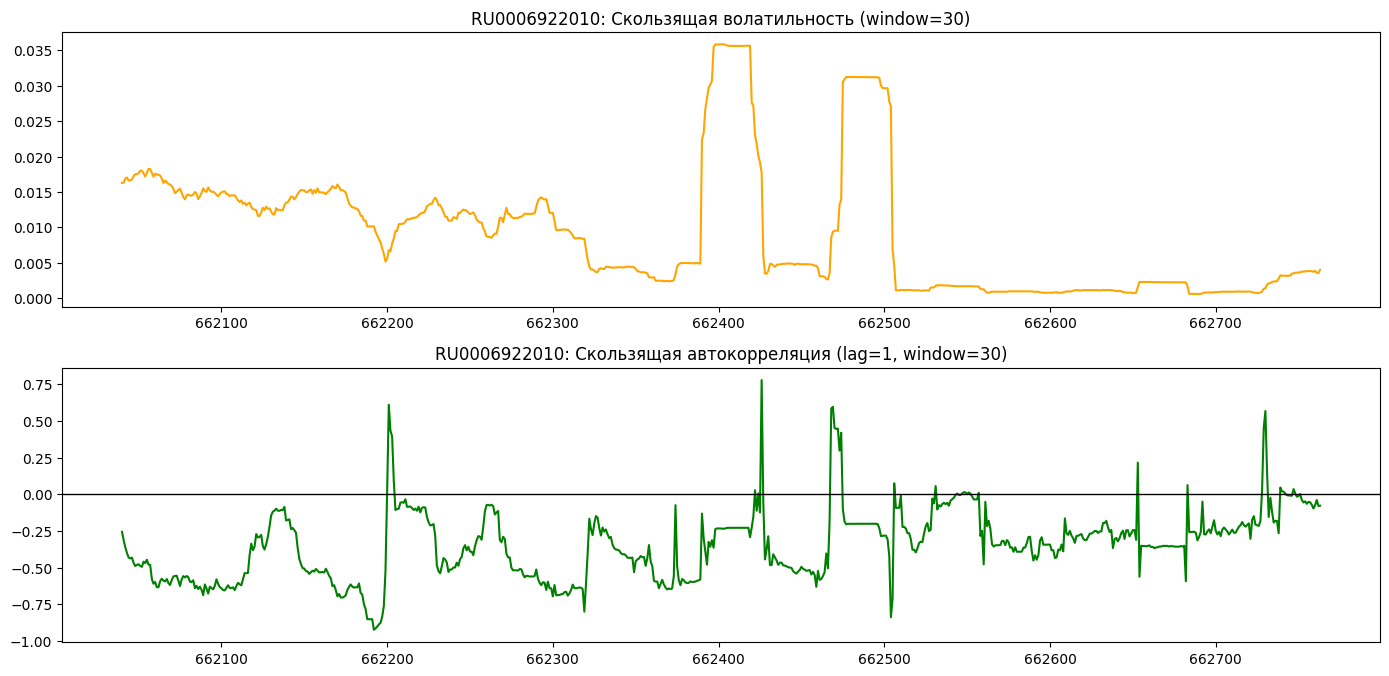

In [27]:
analyze_timeseries(data[data['secid'] == 'RU0006922010'][target], window=30, secid="RU0006922010")

## Функция для создания гистограмм

In [28]:
def create_and_save_hist(accuracies, name):
    counts, bins = np.histogram(voting_direction_accuracies, bins=10)
    
    centers = (bins[:-1] + bins[1:]) / 2

    fig, ax = plt.subplots()
    ax.bar(centers, counts, width=np.diff(bins))
    
    ax.set_xlabel('Точность')
    ax.set_ylabel('Количество ценных бумаг')

    for x, c in zip(centers, counts):
        ax.text(x, c, str(int(c)), ha='center', va='bottom', fontsize=8)
        
    name_fig = f"{name}.png"
    save_path = os.path.join('Анализ', name_fig)
    
    plt.title(name)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


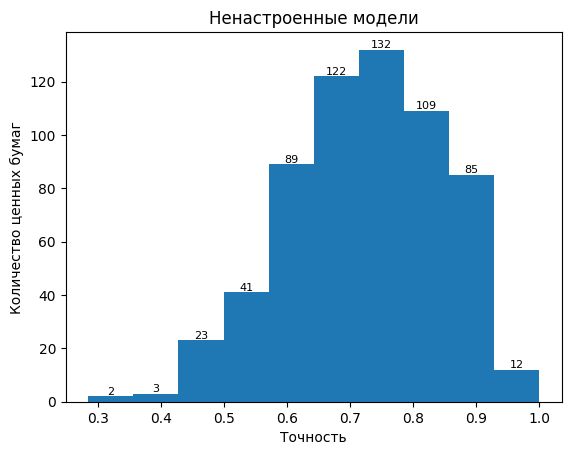

In [29]:
create_and_save_hist(voting_direction_accuracies, 'Ненастроенные модели')

# Сравнение настроенных и ненастроенных моделей

## XGBRegressor

In [30]:
direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    xgb = XGBRegressor(random_state=44, n_jobs=-1)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy) 
    smapes.append(smape)

print(f'Средний показатель direction accuracy НЕнастроенной модели XGBRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE НЕнастроенной модели XGBRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    xgb = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, reg_alpha=0.5, reg_lambda=1.5, random_state=44, n_jobs=-1)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'\nСредний показатель direction accuracy настроенной модели XGBRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE настроенной модели XGBRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Средний показатель direction accuracy НЕнастроенной модели XGBRegressor = 0.7025
# Средний показатель SMAPE НЕнастроенной модели XGBRegressor = 108.8434
# Количество ценных бумаг с результатом direction accuracy < 55%: 57
# Количество ценных бумаг с результатом direction accuracy > 95%: 5

# Средний показатель direction accuracy настроенной модели XGBRegressor = 0.7423
# Средний показатель SMAPE настроенной модели XGBRegressor = 104.2157
# Количество ценных бумаг с результатом direction accuracy < 55%: 37
# Количество ценных бумаг с результатом direction accuracy > 95%: 7

Processing: 100%|█████████████████████████████| 618/618 [02:30<00:00,  4.11it/s]


Средний показатель direction accuracy НЕнастроенной модели XGBRegressor = 0.7025
Средний показатель SMAPE НЕнастроенной модели XGBRegressor = 108.8434
Количество ценных бумаг с результатом direction accuracy < 55%: 57
Количество ценных бумаг с результатом direction accuracy > 95%: 5


Processing: 100%|█████████████████████████████| 618/618 [01:57<00:00,  5.24it/s]


Средний показатель direction accuracy настроенной модели XGBRegressor = 0.7423
Средний показатель SMAPE настроенной модели XGBRegressor = 104.2157
Количество ценных бумаг с результатом direction accuracy < 55%: 37
Количество ценных бумаг с результатом direction accuracy > 95%: 7


## LGBMRegressor

In [31]:
direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    lgbm = LGBMRegressor(verbose=-1, random_state=44, n_jobs=-1)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'Средний показатель direction accuracy НЕнастроенной модели LGBMRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE НЕнастроенной модели LGBMRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    lgbm = LGBMRegressor(min_data_in_leaf=100, max_bin=256, verbose=-1, random_state=44, n_jobs=-1)
    lgbm.fit(X_train, y_train)
    y_pred = lgbm.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'\nСредний показатель direction accuracy настроенной модели LGBMRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE настроенной модели LGBMRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Средний показатель direction accuracy НЕнастроенной модели LGBMRegressor = 0.7060
# Средний показатель SMAPE НЕнастроенной модели LGBMRegressor = 108.4575
# Количество ценных бумаг с результатом direction accuracy < 55%: 66
# Количество ценных бумаг с результатом direction accuracy > 95%: 2

# Средний показатель direction accuracy настроенной модели LGBMRegressor = 0.7206
# Средний показатель SMAPE настроенной модели LGBMRegressor = 107.6480
# Количество ценных бумаг с результатом direction accuracy < 55%: 48
# Количество ценных бумаг с результатом direction accuracy > 95%: 3


Processing: 100%|█████████████████████████████| 618/618 [00:59<00:00, 10.43it/s]


Средний показатель direction accuracy НЕнастроенной модели LGBMRegressor = 0.7060
Средний показатель SMAPE НЕнастроенной модели LGBMRegressor = 108.4575
Количество ценных бумаг с результатом direction accuracy < 55%: 66
Количество ценных бумаг с результатом direction accuracy > 95%: 2


Processing: 100%|█████████████████████████████| 618/618 [00:32<00:00, 19.01it/s]


Средний показатель direction accuracy настроенной модели LGBMRegressor = 0.7206
Средний показатель SMAPE настроенной модели LGBMRegressor = 107.6480
Количество ценных бумаг с результатом direction accuracy < 55%: 48
Количество ценных бумаг с результатом direction accuracy > 95%: 3


## HistGradientBoostingRegressor

In [32]:
direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    hgb = HistGradientBoostingRegressor(random_state=44)
    hgb.fit(X_train, y_train)
    y_pred = hgb.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy) 
    smapes.append(smape)

print(f'Средний показатель direction accuracy НЕнастроенной модели HistGradientBoostingRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE НЕнастроенной модели HistGradientBoostingRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    hgb = HistGradientBoostingRegressor(max_iter=150, learning_rate=0.03, l2_regularization=20, max_depth=5, random_state=44)
    hgb.fit(X_train, y_train)
    y_pred = hgb.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'\nСредний показатель direction accuracy настроенной модели HistGradientBoostingRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE настроенной модели HistGradientBoostingRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Средний показатель direction accuracy НЕнастроенной модели HistGradientBoostingRegressor = 0.7083
# Средний показатель SMAPE НЕнастроенной модели HistGradientBoostingRegressor = 108.2187
# Количество ценных бумаг с результатом direction accuracy < 55%: 61
# Количество ценных бумаг с результатом direction accuracy > 95%: 3

# Средний показатель direction accuracy настроенной модели HistGradientBoostingRegressor = 0.7412
# Средний показатель SMAPE настроенной модели HistGradientBoostingRegressor = 101.6070
# Количество ценных бумаг с результатом direction accuracy < 55%: 45
# Количество ценных бумаг с результатом direction accuracy > 95%: 4


Processing: 100%|█████████████████████████████| 618/618 [02:53<00:00,  3.56it/s]


Средний показатель direction accuracy НЕнастроенной модели HistGradientBoostingRegressor = 0.7083
Средний показатель SMAPE НЕнастроенной модели HistGradientBoostingRegressor = 108.2187
Количество ценных бумаг с результатом direction accuracy < 55%: 61
Количество ценных бумаг с результатом direction accuracy > 95%: 3


Processing: 100%|█████████████████████████████| 618/618 [01:54<00:00,  5.38it/s]


Средний показатель direction accuracy настроенной модели HistGradientBoostingRegressor = 0.7412
Средний показатель SMAPE настроенной модели HistGradientBoostingRegressor = 101.6070
Количество ценных бумаг с результатом direction accuracy < 55%: 45
Количество ценных бумаг с результатом direction accuracy > 95%: 4


## RandomForestRegressor

In [33]:
direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    rf = RandomForestRegressor(random_state=44, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy) 
    smapes.append(smape)

print(f'Средний показатель direction accuracy НЕнастроенной модели RandomForestRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE НЕнастроенной модели RandomForestRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=16, min_samples_leaf=10, max_features=0.8, random_state=44, n_jobs=-1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'\nСредний показатель direction accuracy настроенной модели RandomForestRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE настроенной модели RandomForestRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Средний показатель direction accuracy НЕнастроенной модели RandomForestRegressor = 0.7270
# Средний показатель SMAPE НЕнастроенной модели RandomForestRegressor = 102.9727
# Количество ценных бумаг с результатом direction accuracy < 55%: 39
# Количество ценных бумаг с результатом direction accuracy > 95%: 6

# Средний показатель direction accuracy настроенной модели RandomForestRegressor = 0.7523
# Средний показатель SMAPE настроенной модели RandomForestRegressor = 97.5782
# Количество ценных бумаг с результатом direction accuracy < 55%: 29
# Количество ценных бумаг с результатом direction accuracy > 95%: 5


Processing: 100%|█████████████████████████████| 618/618 [10:30<00:00,  1.02s/it]


Средний показатель direction accuracy НЕнастроенной модели RandomForestRegressor = 0.7270
Средний показатель SMAPE НЕнастроенной модели RandomForestRegressor = 102.9727
Количество ценных бумаг с результатом direction accuracy < 55%: 39
Количество ценных бумаг с результатом direction accuracy > 95%: 6


Processing: 100%|█████████████████████████████| 618/618 [08:47<00:00,  1.17it/s]


Средний показатель direction accuracy настроенной модели RandomForestRegressor = 0.7523
Средний показатель SMAPE настроенной модели RandomForestRegressor = 97.5782
Количество ценных бумаг с результатом direction accuracy < 55%: 29
Количество ценных бумаг с результатом direction accuracy > 95%: 5


## ExtraTreesRegressor

In [34]:
direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    et = ExtraTreesRegressor(random_state=44, n_jobs=-1)
    et.fit(X_train, y_train)
    y_pred = et.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'Средний показатель direction accuracy НЕнастроенной модели ExtraTreesRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE НЕнастроенной модели ExtraTreesRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    et = ExtraTreesRegressor(n_estimators=200, max_depth=15, min_samples_split=8, min_samples_leaf=4, max_features=0.8, bootstrap=False, random_state=44, n_jobs=-1)
    et.fit(X_train, y_train)
    y_pred = et.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'\nСредний показатель direction accuracy настроенной модели ExtraTreesRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE настроенной модели ExtraTreesRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Средний показатель direction accuracy НЕнастроенной модели ExtraTreesRegressor = 0.7310
# Средний показатель SMAPE НЕнастроенной модели ExtraTreesRegressor = 101.3770
# Количество ценных бумаг с результатом direction accuracy < 55%: 33
# Количество ценных бумаг с результатом direction accuracy > 95%: 4

# Средний показатель direction accuracy настроенной модели ExtraTreesRegressor = 0.7486
# Средний показатель SMAPE настроенной модели ExtraTreesRegressor = 98.4191
# Количество ценных бумаг с результатом direction accuracy < 55%: 31
# Количество ценных бумаг с результатом direction accuracy > 95%: 5


Processing: 100%|█████████████████████████████| 618/618 [03:26<00:00,  3.00it/s]


Средний показатель direction accuracy НЕнастроенной модели ExtraTreesRegressor = 0.7310
Средний показатель SMAPE НЕнастроенной модели ExtraTreesRegressor = 101.3770
Количество ценных бумаг с результатом direction accuracy < 55%: 33
Количество ценных бумаг с результатом direction accuracy > 95%: 4


Processing: 100%|█████████████████████████████| 618/618 [03:04<00:00,  3.35it/s]


Средний показатель direction accuracy настроенной модели ExtraTreesRegressor = 0.7486
Средний показатель SMAPE настроенной модели ExtraTreesRegressor = 98.4191
Количество ценных бумаг с результатом direction accuracy < 55%: 31
Количество ценных бумаг с результатом direction accuracy > 95%: 5


## Ridge

In [35]:
direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    ridge = Ridge()
    ridge_pipeline = Pipeline([('scaler', StandardScaler()), ('ridge', ridge)])
    ridge_pipeline.fit(X_train, y_train)
    y_pred = ridge_pipeline.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'Средний показатель direction accuracy НЕнастроенной модели Ridge = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE НЕнастроенной модели Ridge = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    ridge = Ridge(alpha=0.9)
    ridge_pipeline = Pipeline([('scaler', StandardScaler()), ('ridge', ridge)])
    ridge_pipeline.fit(X_train, y_train)
    y_pred = ridge_pipeline.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'\nСредний показатель direction accuracy настроенной модели Ridge = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE настроенной модели Ridge = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Средний показатель direction accuracy НЕнастроенной модели Ridge = 0.7149
# Средний показатель SMAPE НЕнастроенной модели Ridge = 107.2504
# Количество ценных бумаг с результатом direction accuracy < 55%: 59
# Количество ценных бумаг с результатом direction accuracy > 95%: 3

# Средний показатель direction accuracy настроенной модели Ridge = 0.7150
# Средний показатель SMAPE настроенной модели Ridge = 107.2595
# Количество ценных бумаг с результатом direction accuracy < 55%: 58
# Количество ценных бумаг с результатом direction accuracy > 95%: 3
    

Processing: 100%|█████████████████████████████| 618/618 [00:06<00:00, 88.60it/s]


Средний показатель direction accuracy НЕнастроенной модели Ridge = 0.7149
Средний показатель SMAPE НЕнастроенной модели Ridge = 107.2504
Количество ценных бумаг с результатом direction accuracy < 55%: 59
Количество ценных бумаг с результатом direction accuracy > 95%: 3


Processing: 100%|█████████████████████████████| 618/618 [00:06<00:00, 89.10it/s]


Средний показатель direction accuracy настроенной модели Ridge = 0.7150
Средний показатель SMAPE настроенной модели Ridge = 107.2595
Количество ценных бумаг с результатом direction accuracy < 55%: 58
Количество ценных бумаг с результатом direction accuracy > 95%: 3


## KNeighborsRegressor

In [36]:
direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    knn = KNeighborsRegressor(n_jobs=-1)
    knn_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', knn)])
    knn_pipeline.fit(X_train, y_train)
    y_pred = knn_pipeline.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'Средний показатель direction accuracy НЕнастроенной модели KNeighborsRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE НЕнастроенной модели XGBRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

direction_accuracies = []
smapes = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    knn = KNeighborsRegressor(n_neighbors=20, weights='distance', metric='cosine', n_jobs=-1)
    knn_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', knn)])
    knn_pipeline.fit(X_train, y_train)
    y_pred = knn_pipeline.predict(X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    direction_accuracies.append(direction_accuracy)
    smapes.append(smape)

print(f'\nСредний показатель direction accuracy настроенной модели KNeighborsRegressor = {np.mean(direction_accuracies):.4f}')
print(f'Средний показатель SMAPE настроенной модели KNeighborsRegressor = {np.mean(smapes):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Средний показатель direction accuracy НЕнастроенной модели KNeighborsRegressor = 0.6062
# Средний показатель SMAPE НЕнастроенной модели XGBRegressor = 135.2546
# Количество ценных бумаг с результатом direction accuracy < 55%: 146
# Количество ценных бумаг с результатом direction accuracy > 95%: 3

# Средний показатель direction accuracy настроенной модели KNeighborsRegressor = 0.6329
# Средний показатель SMAPE настроенной модели KNeighborsRegressor = 138.0007
# Количество ценных бумаг с результатом direction accuracy < 55%: 102
# Количество ценных бумаг с результатом direction accuracy > 95%: 4
    

Processing: 100%|█████████████████████████████| 618/618 [00:07<00:00, 78.92it/s]


Средний показатель direction accuracy НЕнастроенной модели KNeighborsRegressor = 0.6062
Средний показатель SMAPE НЕнастроенной модели XGBRegressor = 135.2546
Количество ценных бумаг с результатом direction accuracy < 55%: 146
Количество ценных бумаг с результатом direction accuracy > 95%: 3


Processing: 100%|█████████████████████████████| 618/618 [00:29<00:00, 20.62it/s]


Средний показатель direction accuracy настроенной модели KNeighborsRegressor = 0.6329
Средний показатель SMAPE настроенной модели KNeighborsRegressor = 138.0007
Количество ценных бумаг с результатом direction accuracy < 55%: 102
Количество ценных бумаг с результатом direction accuracy > 95%: 4


# Модели с настроенными гиперпараметрами

## Все, без весов в Voting

In [37]:
def get_base_tuned_models():
    xgb = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, reg_alpha=0.5, reg_lambda=1.5, random_state=44, n_jobs=-1)
    lgbm = LGBMRegressor(min_data_in_leaf=100, max_bin=256, verbose=-1, random_state=44, n_jobs=-1)
    hgb = HistGradientBoostingRegressor(max_iter=150, learning_rate=0.03, l2_regularization=20, max_depth=5, random_state=44)
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=16, min_samples_leaf=10, max_features=0.8, random_state=44, n_jobs=-1)
    et = ExtraTreesRegressor(n_estimators=200, max_depth=15, min_samples_split=8, min_samples_leaf=4, max_features=0.8, bootstrap=False, random_state=44, n_jobs=-1)
    ridge = Ridge(alpha=0.9)
    knn = KNeighborsRegressor(n_neighbors=20, weights='distance', metric='cosine', n_jobs=-1)
    ridge_pipeline = Pipeline([('scaler', StandardScaler()), ('ridge', ridge)])
    knn_pipeline = Pipeline([('scaler', StandardScaler()), ('knn', knn)])
    models = [
        ('xgb', xgb),
        ('lgbm', lgbm),
        ('hgb', hgb),
        ('rf', rf),
        ('et', et),
        ('ridge', ridge_pipeline),
        ('knn', knn_pipeline)
    ]
    return models

In [38]:
def fit_and_predict_tuned(X_train, y_train, X_test):
    voting = VotingRegressor(estimators=get_base_tuned_models())
    voting.fit(X_train, y_train)
    y_pred = voting.predict(X_test)
    return y_pred

In [39]:
voting_smapes = []
voting_direction_accuracies = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    y_pred = fit_and_predict_tuned(X_train, y_train, X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    voting_smapes.append(smape)
    voting_direction_accuracies.append(direction_accuracy)
    
print(f'Voting SMAPE mean = {np.mean(voting_smapes):.4f}, direction accuracy mean = {np.mean(voting_direction_accuracies):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Voting SMAPE mean = 102.5804, direction accuracy mean = 0.7422
# Количество ценных бумаг с результатом direction accuracy < 55%: 44
# Количество ценных бумаг с результатом direction accuracy > 95%: 5


Processing: 100%|█████████████████████████████| 618/618 [17:54<00:00,  1.74s/it]

Voting SMAPE mean = 102.5804, direction accuracy mean = 0.7422
Количество ценных бумаг с результатом direction accuracy < 55%: 44
Количество ценных бумаг с результатом direction accuracy > 95%: 5


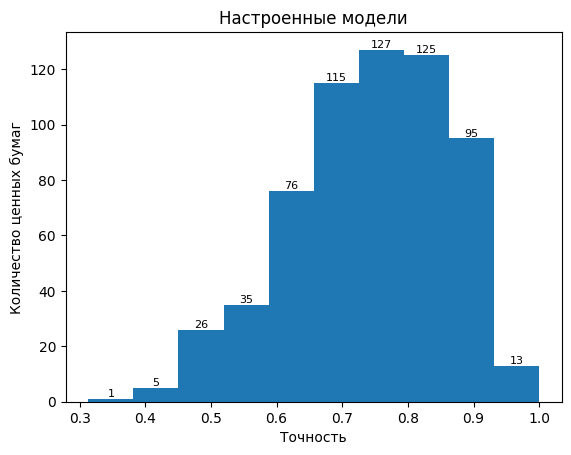

In [40]:
create_and_save_hist(voting_direction_accuracies, 'Настроенные модели')

## Все, но с весами

In [41]:
def fit_and_predict_with_weights(X_train, y_train, X_test):
    weights = [0.15, 0.1, 0.15, 0.3, 0.2, 0.09, 0.01]
    voting = VotingRegressor(estimators=get_base_tuned_models(), weights=weights)
    voting.fit(X_train, y_train)
    y_pred = voting.predict(X_test)
    return y_pred

In [42]:
voting_smapes = []
voting_direction_accuracies = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    y_pred = fit_and_predict_with_weights(X_train, y_train, X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    voting_smapes.append(smape)
    voting_direction_accuracies.append(direction_accuracy)
    
print(f'Voting SMAPE mean = {np.mean(voting_smapes):.4f}, direction accuracy mean = {np.mean(voting_direction_accuracies):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Voting SMAPE mean = 99.7530, direction accuracy mean = 0.7461
# Количество ценных бумаг с результатом direction accuracy < 55%: 45
# Количество ценных бумаг с результатом direction accuracy > 95%: 5


Processing: 100%|█████████████████████████████| 618/618 [17:56<00:00,  1.74s/it]

Voting SMAPE mean = 99.7530, direction accuracy mean = 0.7461
Количество ценных бумаг с результатом direction accuracy < 55%: 45
Количество ценных бумаг с результатом direction accuracy > 95%: 5


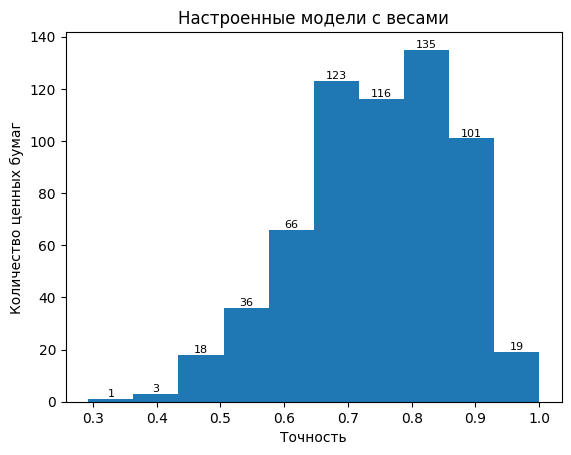

In [43]:
create_and_save_hist(voting_direction_accuracies, 'Настроенные модели с весами')

## Только самые сильные

In [44]:
def get_strongest_base_tuned_models():
    xgb = XGBRegressor(n_estimators=150, learning_rate=0.1, max_depth=5, reg_alpha=0.5, reg_lambda=1.5, random_state=44, n_jobs=-1)
    rf = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=16, min_samples_leaf=10, max_features=0.8, random_state=44, n_jobs=-1)
    et = ExtraTreesRegressor(n_estimators=200, max_depth=15, min_samples_split=8, min_samples_leaf=4, max_features=0.8, bootstrap=False, random_state=44, n_jobs=-1)
    models = [
        ('xgb', xgb),
        ('rf', rf),
        ('et', et)
    ]
    return models

In [45]:
def fit_and_predict_strongest(X_train, y_train, X_test):
    voting = VotingRegressor(estimators=get_strongest_base_tuned_models())
    voting.fit(X_train, y_train)
    y_pred = voting.predict(X_test)
    return y_pred

In [46]:
voting_smapes = []
voting_direction_accuracies = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    y_pred = fit_and_predict_strongest(X_train, y_train, X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    voting_smapes.append(smape)
    voting_direction_accuracies.append(direction_accuracy)
    
print(f'Voting SMAPE mean = {np.mean(voting_smapes):.4f}, direction accuracy mean = {np.mean(voting_direction_accuracies):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Voting SMAPE mean = 98.3007, direction accuracy mean = 0.7528
# Количество ценных бумаг с результатом direction accuracy < 55%: 33
# Количество ценных бумаг с результатом direction accuracy > 95%: 6


Processing: 100%|█████████████████████████████| 618/618 [14:42<00:00,  1.43s/it]

Voting SMAPE mean = 98.3007, direction accuracy mean = 0.7528
Количество ценных бумаг с результатом direction accuracy < 55%: 33
Количество ценных бумаг с результатом direction accuracy > 95%: 6


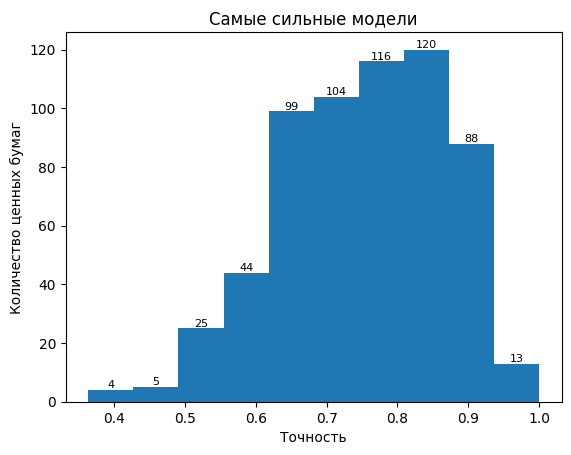

In [47]:
create_and_save_hist(voting_direction_accuracies, 'Самые сильные модели')

## Самые сильные с весами

In [48]:
def fit_and_predict_strongest_with_weights(X_train, y_train, X_test):
    weights = [0.1, 0.8, 0.1]
    voting = VotingRegressor(estimators=get_strongest_base_tuned_models(), weights=weights)
    voting.fit(X_train, y_train)
    y_pred = voting.predict(X_test)
    return y_pred

In [49]:
voting_smapes = []
voting_direction_accuracies = []
bad_results = {}
good_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    y_pred = fit_and_predict_strongest_with_weights(X_train, y_train, X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        bad_results[secid] = direction_accuracy
    if direction_accuracy > 0.95:
        good_results[secid] = direction_accuracy
    voting_smapes.append(smape)
    voting_direction_accuracies.append(direction_accuracy)
    
print(f'Voting SMAPE mean = {np.mean(voting_smapes):.4f}, direction accuracy mean = {np.mean(voting_direction_accuracies):.4f}')
print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

# Voting SMAPE mean = 97.5133, direction accuracy mean = 0.7531
# Количество ценных бумаг с результатом direction accuracy < 55%: 28
# Количество ценных бумагкомпаний с результатом direction accuracy > 95%: 5


Processing: 100%|█████████████████████████████| 618/618 [14:30<00:00,  1.41s/it]

Voting SMAPE mean = 97.5133, direction accuracy mean = 0.7531
Количество ценных бумаг с результатом direction accuracy < 55%: 28
Количество ценных бумаг с результатом direction accuracy > 95%: 5


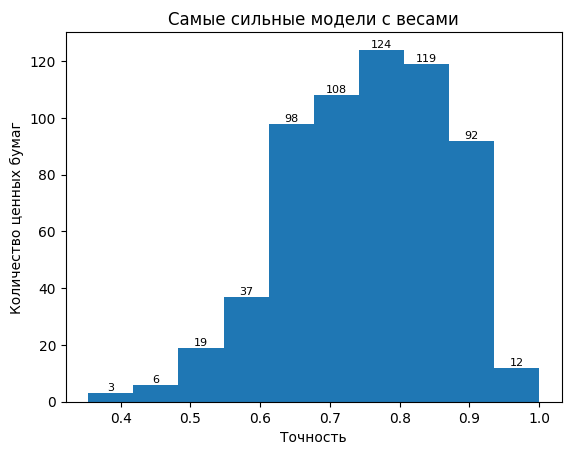

In [50]:
create_and_save_hist(voting_direction_accuracies, 'Самые сильные модели с весами')

In [51]:
width = 12
print('Bad results:')
for key, value in bad_results.items():
    print(f'{key:>{width}}: {value:.4f}')
    
print('\nGood results:')
for key, value in good_results.items():
    print(f'{key:>{width}}: {value:.4f}') 

Bad results:
        FXGD: 0.5426
        FXIT: 0.5342
        FXTB: 0.5252
        FXUS: 0.5286
        KAZT: 0.5101
        KOSB: 0.5205
        PRIM: 0.5408
        RCUS: 0.5128
RU0006922010: 0.4702
RU000A0JNFU5: 0.5200
RU000A0JR4W5: 0.3784
RU000A0JRHC0: 0.5138
RU000A0JX1H4: 0.4225
RU000A0JXP78: 0.5093
RU000A102PE0: 0.3535
        RUSB: 0.4865
        RUSE: 0.4895
        SCIP: 0.4375
        SNOS: 0.4940
        TAER: 0.4245
        TECH: 0.4648
        TEUR: 0.5182
        TGKE: 0.5114
        TGKF: 0.4974
        UUAZ: 0.5102
       VRAOP: 0.5185
        VTBU: 0.4020
        YUAN: 0.4545

Good results:
        AKMM: 0.9917
        LQDT: 1.0000
        SBMM: 1.0000
        SMLT: 0.9592
        VTBM: 0.9817


## Перекрестная проверка

In [58]:
for train_size in np.arange(0.5, 1, 0.1):
    voting_smapes = []
    voting_direction_accuracies = []
    bad_results = {}
    good_results = {}
    for secid, group in tqdm(data_grouped, desc=f'Processing: train_size = {int(train_size*100)}%'):
        X_train, y_train, X_test, y_test = get_sample(group, features, target, train_size=train_size)
        y_pred = fit_and_predict_strongest_with_weights(X_train, y_train, X_test)
        smape, direction_accuracy = get_evaluations(y_test, y_pred)
        if direction_accuracy < 0.55:
            bad_results[secid] = direction_accuracy
        if direction_accuracy > 0.95:
            good_results[secid] = direction_accuracy
        voting_smapes.append(smape)
        voting_direction_accuracies.append(direction_accuracy)
    print(f'Тестовая выборка {int(train_size*100)}%')
    print(f'Voting SMAPE mean = {np.mean(voting_smapes):.4f}, direction accuracy mean = {np.mean(voting_direction_accuracies):.4f}')
    print(f'Количество ценных бумаг с результатом direction accuracy < 55%: {len(bad_results)}')
    print(f'Количество ценных бумаг с результатом direction accuracy > 95%: {len(good_results)}')

Processing: train_size = 50%: 100%|███████████| 618/618 [11:40<00:00,  1.13s/it]


Тестовая выборка 50%
Voting SMAPE mean = 103.9513, direction accuracy mean = 0.7292
Количество ценных бумаг с результатом direction accuracy < 55%: 34
Количество ценных бумаг с результатом direction accuracy > 95%: 1


Processing: train_size = 60%: 100%|███████████| 618/618 [13:15<00:00,  1.29s/it]


Тестовая выборка 60%
Voting SMAPE mean = 102.2531, direction accuracy mean = 0.7361
Количество ценных бумаг с результатом direction accuracy < 55%: 37
Количество ценных бумаг с результатом direction accuracy > 95%: 3


Processing: train_size = 70%: 100%|███████████| 618/618 [14:45<00:00,  1.43s/it]


Тестовая выборка 70%
Voting SMAPE mean = 100.7001, direction accuracy mean = 0.7451
Количество ценных бумаг с результатом direction accuracy < 55%: 35
Количество ценных бумаг с результатом direction accuracy > 95%: 6


Processing: train_size = 80%: 100%|███████████| 618/618 [16:33<00:00,  1.61s/it]


Тестовая выборка 80%
Voting SMAPE mean = 97.4984, direction accuracy mean = 0.7531
Количество ценных бумаг с результатом direction accuracy < 55%: 30
Количество ценных бумаг с результатом direction accuracy > 95%: 5


Processing: train_size = 89%: 100%|███████████| 618/618 [17:54<00:00,  1.74s/it]

Тестовая выборка 89%
Voting SMAPE mean = 95.9174, direction accuracy mean = 0.7558
Количество ценных бумаг с результатом direction accuracy < 55%: 42
Количество ценных бумаг с результатом direction accuracy > 95%: 8


# Создание графиков с результатами по всем бумгам 

In [59]:
def create_and_save_fig(all_y_true, all_y_pred, secid, smape, direction_accuracy, is_tuned=False):
    folder_path = "Результаты"
    os.makedirs(folder_path, exist_ok=True)

    fig, ax = plt.subplots(figsize=(12, 6))
    
    time_index = range(len(all_y_true))
    
    ax.plot(time_index, all_y_true, c='green', alpha=0.8, linewidth=1.5, 
            label='Истинные значения', marker='o', markersize=3)
    ax.plot(time_index, all_y_pred, c='red', alpha=0.8, linewidth=1.5, 
            label='Предсказанные значения', marker='s', markersize=3)
    
    ax.set_xlabel('Наблюдения')
    ax.set_ylabel('Доходность')
    ax.set_title(f'{secid} - Сравнение истинных и предсказанных значений\n'
                f'{"(настроенная модель)" if is_tuned else "(базовая модель)"}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    

    textstr = f'SMAPE: {smape:.2f}%\nТочность направления: {direction_accuracy:.2%}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    
    name_fig = f"{secid}{'_tuned' if is_tuned else '_regular'}.png"

    save_path = os.path.join(folder_path, name_fig)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

In [60]:
data_grouped = data.groupby('secid')
voting_smapes = []
voting_direction_accuracies = []

all_y_pred = []
all_y_true = []

companies_with_bad_results = {}
for secid, group in tqdm(data_grouped, desc="Processing"):
    X_train, y_train, X_test, y_test = get_sample(group, features, target)
    all_y_true.append(y_test.to_numpy())
    y_pred = fit_and_predict(X_train, y_train, X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    create_and_save_fig(y_test.to_numpy(), y_pred, secid, smape, direction_accuracy, is_tuned=False)
    
    y_pred = fit_and_predict_strongest_with_weights(X_train, y_train, X_test)
    smape, direction_accuracy = get_evaluations(y_test, y_pred)
    if direction_accuracy < 0.55:
        companies_with_bad_results[secid] = direction_accuracy
    
    create_and_save_fig(y_test.to_numpy(), y_pred, secid, smape, direction_accuracy, is_tuned=True)
    
    voting_smapes.append(smape)
    voting_direction_accuracies.append(direction_accuracy)
    
print(f'Voting SMAPE mean = {np.mean(voting_smapes):.4f}, direction accuracy mean = {np.mean(voting_direction_accuracies):.4f}')

Processing: 100%|███████████████████████████| 618/618 [1:00:57<00:00,  5.92s/it]

Voting SMAPE mean = 97.5133, direction accuracy mean = 0.7531
